In [1]:
# Solving MTSP using KMeans for initialization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from copy import deepcopy
import random
from tqdm import tqdm
from sklearn.cluster import KMeans

In [3]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        g = nx.Graph()

        for line in f:
            if not line[0].isdigit():
                continue

            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)

            g.add_node(node, x=x, y=y)

        for u in g.nodes:
            for v in range(u+1, len(g.nodes)):
                g.add_edge(u,
                           v,
                           distance=euclidian_distance(g.nodes[u]['x'],
                                                       g.nodes[u]['y'],
                                                       g.nodes[v]['x'],
                                                       g.nodes[v]['y']),
                           pheromones=np.random.uniform(1e-5, 1e-2))

        return g

In [4]:
def euclidian_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [5]:
def get_clustered_cities(g, labels):
    clusters = {}
    flag = False # does it contain the start(0) node

    for cluster in range(len(np.unique(labels))):
        xs = []
        ys = []
        clusters[cluster] = []

        for city in range(len(g.nodes)):        
            if labels[city] == cluster:
                xs.append(g.nodes[city]['x'])
                ys.append(g.nodes[city]['y'])
                if city == 0:
                    Flag = True

                clusters[cluster].append(city)
            
        if not flag:
            clusters[cluster].append(0)
            
        flag = False

    return clusters

In [7]:
def traverse(g, start, alpha, beta):
    visited = {}
    for node in g.nodes:
        visited[node] = False
    
    visited[start] = True
    
    route = [start]
    route_length = 0
    
    u = start
    for _ in range(len(g.nodes)-1):
        neighbours = []
        neighbour_values = []
        
        for v in g.nodes:
            if visited[v]:
                continue
            
            distance = g[u][v]['distance']
            pheromones = g[u][v]['pheromones']
                        
            value = pheromones**alpha * (1/distance)**beta
            
            neighbours.append(v)
            neighbour_values.append(value)
       
        
        neighbour_values /= np.sum(neighbour_values)
        next_node = np.random.choice(neighbours, p=neighbour_values)
        visited[next_node] = True
        route.append(next_node)
        route_length += g[u][next_node]['distance']
        u = next_node
        
    route_length += g[route[-1]][route[0]]['distance']
    return route_length, route

In [8]:
def ACO(g, start_node, num_ants, num_iters, alpha, beta, q, rho):
    best_route = None
    best_route_length = float('inf')
    
    
    for _ in tqdm(range(num_iters)):
        routes = [traverse(g=g, start=start_node, alpha=alpha, beta=beta) for _ in range(num_ants)]
        
        # decay
        for u, v in zip(list(g.nodes)[:-1], list(g.nodes)[1:]):
            g[u][v]['pheromones'] *= (1-rho)
        u = list(g.nodes)[0]
        v = list(g.nodes)[-1]
        g[u][v]['pheromones'] *= (1-rho)
        
        # enhancement
        for route_length, route in routes:            
            if route_length < best_route_length:
                best_route = route.copy()
                best_route_length = route_length

            delta = q / route_length

            for u, v in zip(route[:-1], route[1:]):
                g[u][v]['pheromones'] += delta
            g[route[0]][route[-1]]['pheromones'] += delta


    return best_route, best_route_length

In [9]:
def get_random_clusters(g, k):
    nodes = set(g.nodes)
    used_nodes = np.array([])
    clusters = {}
    n = len(nodes)
    
    for i in range(k-1):
        allowed_resources = nodes.difference(set(used_nodes))
        cluster = np.random.choice(list(allowed_resources), size=int(np.floor(n/k)), replace=False)
        if 0 not in cluster:
            cluster = np.append(cluster, 0)
            
        clusters[i] = cluster
        used_nodes = np.append(used_nodes, cluster)
        
    clusters[k-1] = np.array(list(nodes.difference(set(used_nodes))))
    if 0 not in clusters[k-1]:
        clusters[k-1] = np.append(clusters[k-1], 0)
    
    return clusters

In [10]:
def run_random(g, k):
    clusters = get_random_clusters(g, k)    
    routes = []
    total_length = 0

    for cluster in range(k):
        subG = g.subgraph(clusters[cluster])
        m = int(len(subG.nodes) * 1/4)

        route, length = ACO(g=subG, start_node=0, num_iters=100, num_ants=m, alpha=1.5, beta=3, q=100, rho=0.7)
        routes.append(route)
        total_length += length

    #plot_routes(g, routes, total_length)
    return routes, total_length

In [11]:
def run_with_kmeans(g, k):
    model = KMeans(k)
    points = np.array([[g.nodes[i]['x'], g.nodes[i]['y']] for i in range(len(g.nodes))])
    model.fit(points)
    clusters = get_clustered_cities(g, model.labels_)

    routes = []
    total_length = 0

    for cluster in range(k):
        subG = g.subgraph(clusters[cluster])
        m = int(len(subG.nodes) * 1/4)

        route, length = ACO(g=subG, start_node=0, num_iters=100, num_ants=m, alpha=1.5, beta=3, q=100, rho=0.7)
        routes.append(route)
        total_length += length

    return routes, total_length
    #plot_routes(g, routes, total_length)

In [ ]:
##### 1)

In [14]:
km_data = []
rand_data = []


for k in range(2,5):
    g = read_file('Test Instances/berlin52.tsp')
    km_data.append(run_with_kmeans(g, k))
    
    g = read_file('Test Instances/berlin52.tsp')
    rand_data.append(run_random(g,k))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 147.20it/s]


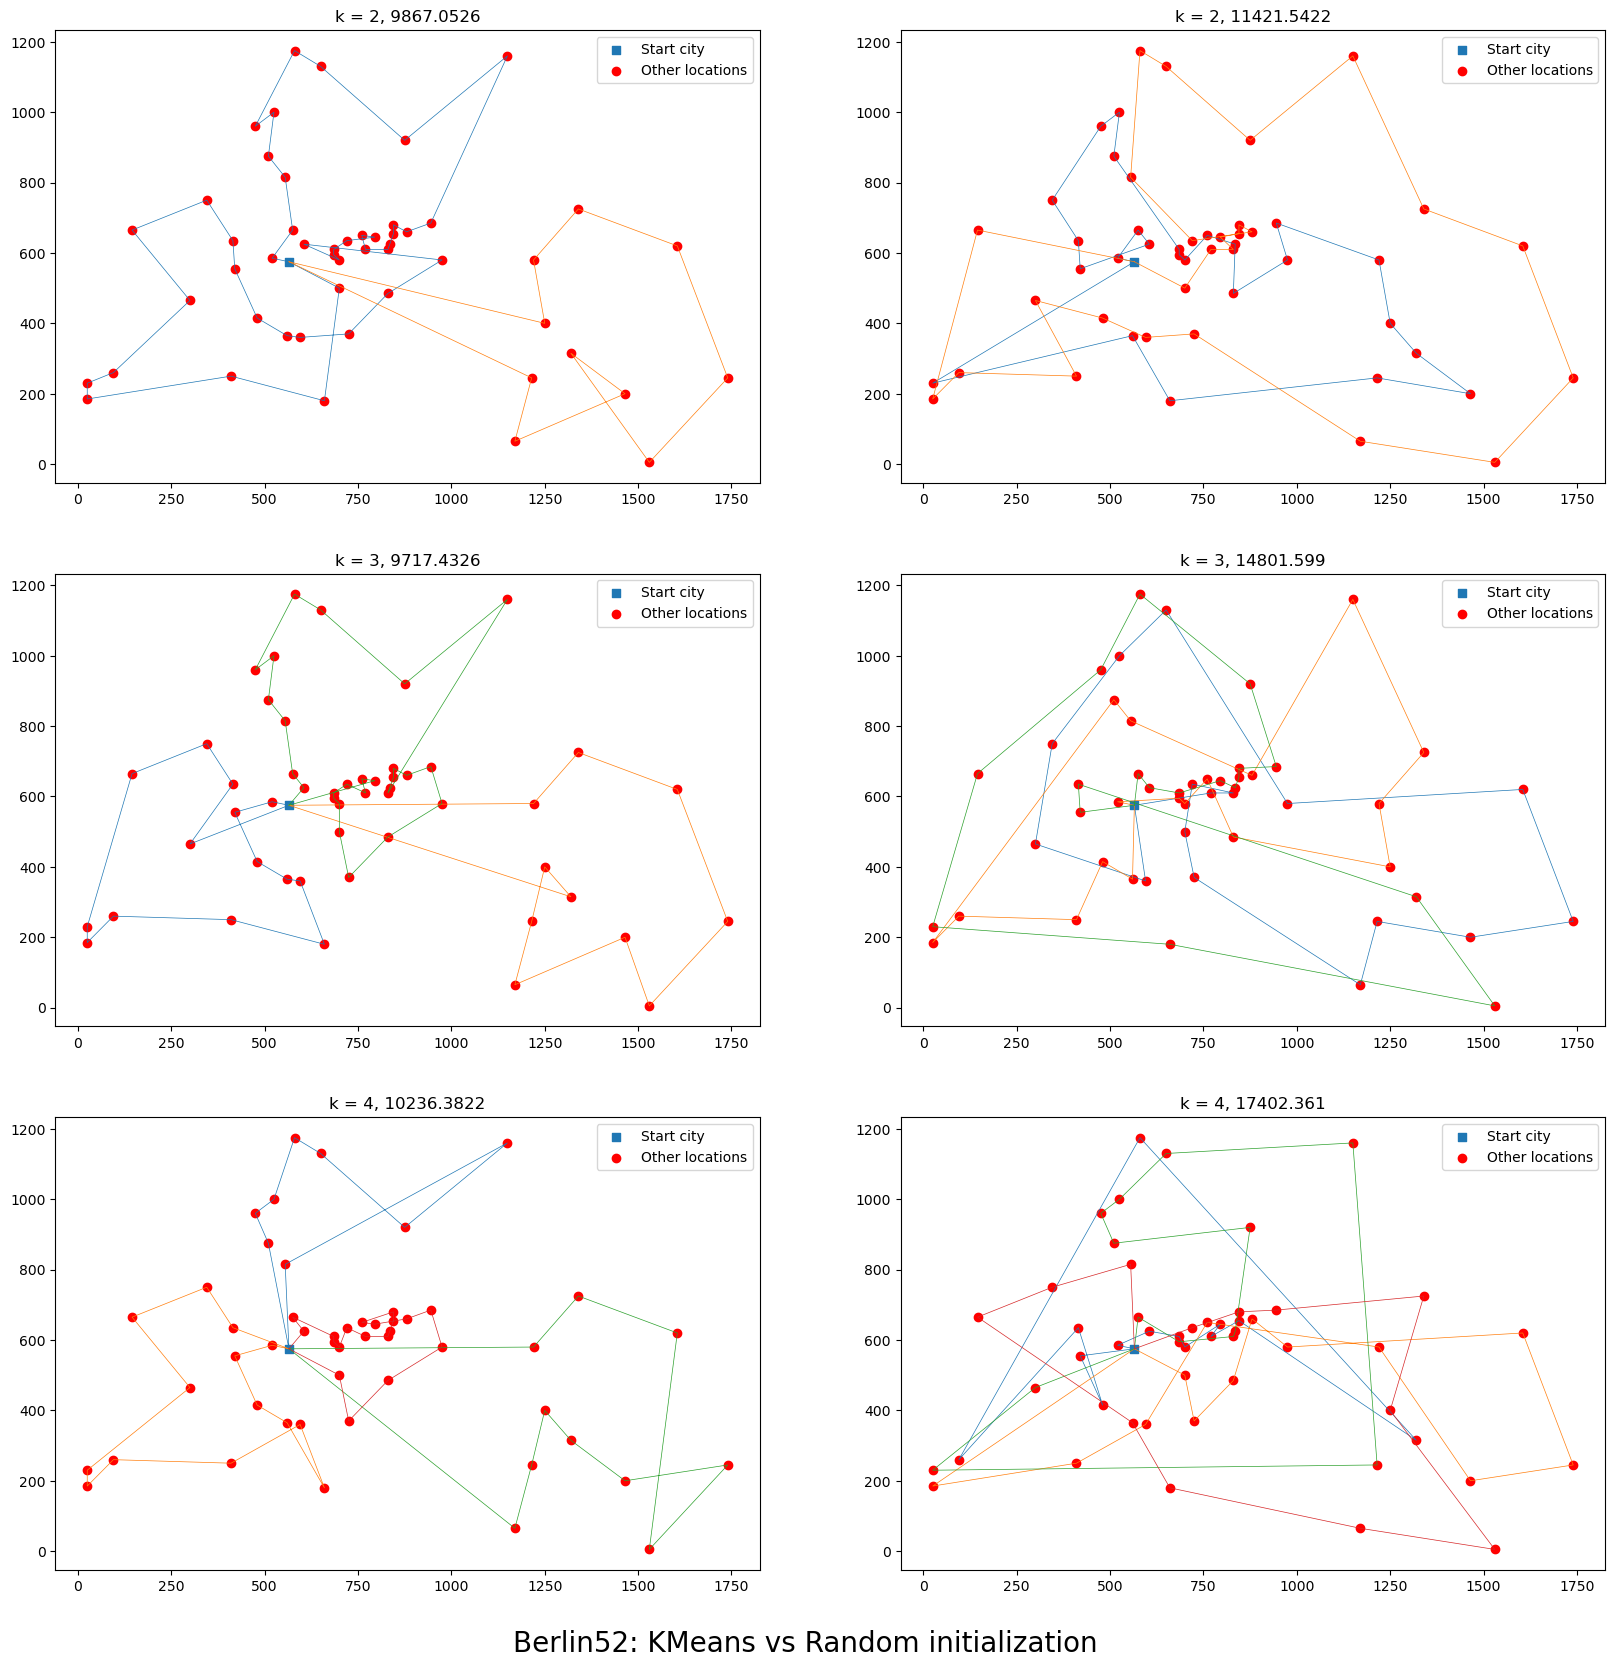

In [40]:
fig, axs = plt.subplots(3,2,figsize=(20,20))

plt.suptitle("Berlin52: KMeans vs Random initialization", y=0.08, fontsize=20)
#plotting KMeans

for i in range(3):
    routes = km_data[i][0]
    length = km_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,0].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,0].scatter(xs[1:], ys[1:], color='red')
    axs[i,0].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,0].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,0].plot(xs, ys, linewidth=0.5)   
    

# plotting random

for i in range(3):
    routes = rand_data[i][0]
    length = rand_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,1].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,1].scatter(xs[1:], ys[1:], color='red')
    axs[i,1].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,1].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,1].plot(xs, ys, linewidth=0.5)

In [ ]:
#### 2)

In [41]:
km_data = []
rand_data = []


for k in range(2,5):
    g = read_file('Test Instances/att48.tsp')
    km_data.append(run_with_kmeans(g, k))
    
    g = read_file('Test Instances/att48.tsp')
    rand_data.append(run_random(g,k))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.04it/s]


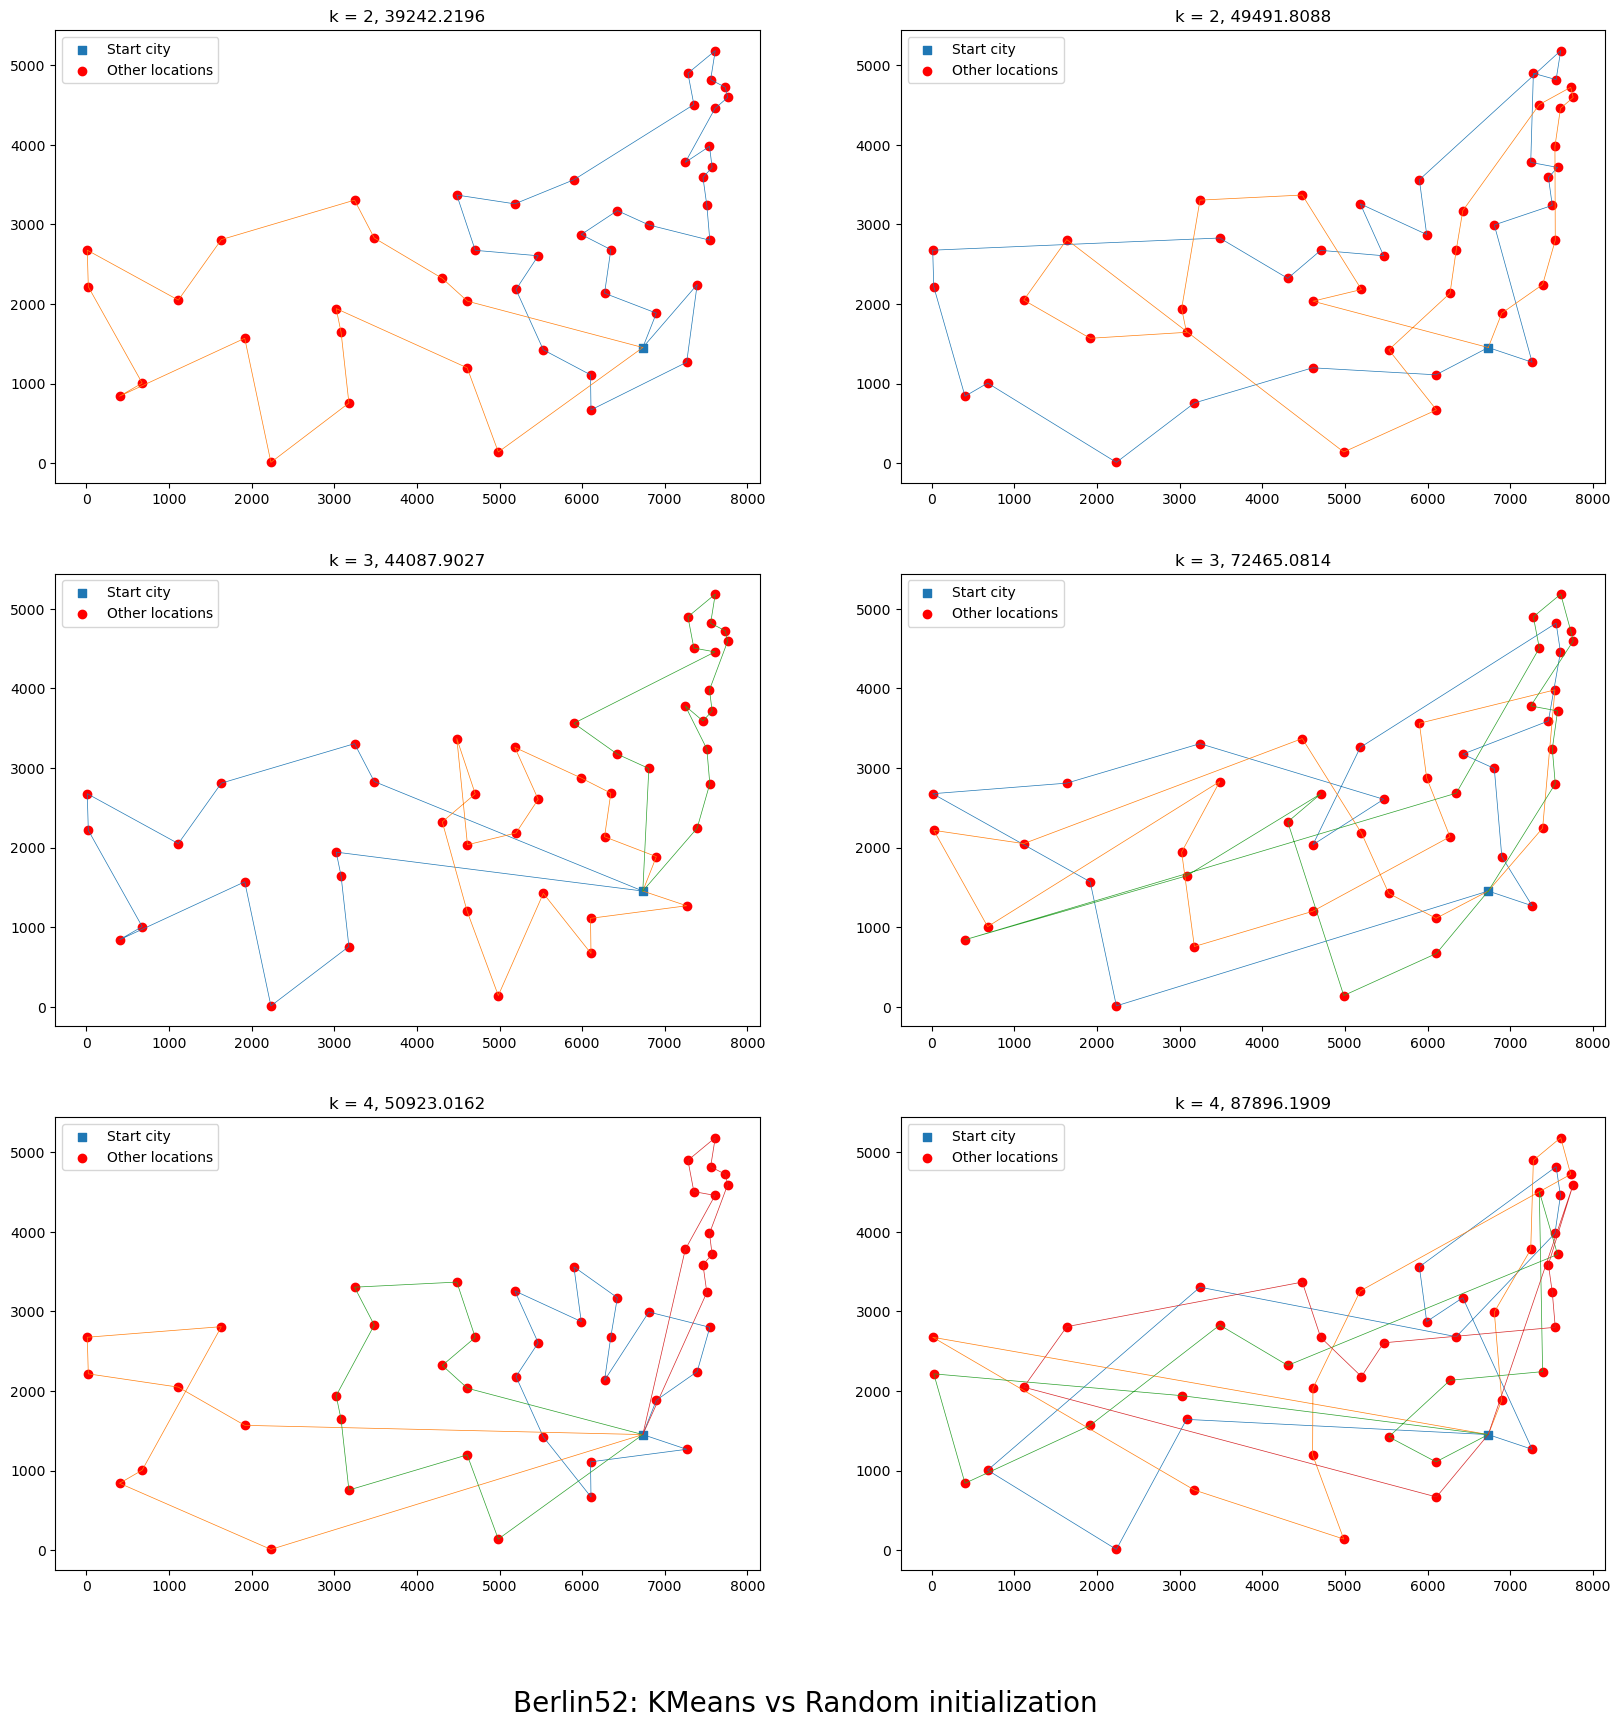

In [42]:
fig, axs = plt.subplots(3,2,figsize=(20,20))

plt.suptitle("Att48: KMeans vs Random initialization", y=0.05, fontsize=20)
#plotting KMeans

for i in range(3):
    routes = km_data[i][0]
    length = km_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,0].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,0].scatter(xs[1:], ys[1:], color='red')
    axs[i,0].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,0].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,0].plot(xs, ys, linewidth=0.5)   
    

# plotting random

for i in range(3):
    routes = rand_data[i][0]
    length = rand_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,1].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,1].scatter(xs[1:], ys[1:], color='red')
    axs[i,1].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,1].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,1].plot(xs, ys, linewidth=0.5)

In [43]:
km_data = []
rand_data = []


for k in range(2,5):
    g = read_file('Test Instances/wi29.tsp')
    km_data.append(run_with_kmeans(g, k))
    
    g = read_file('Test Instances/wi29.tsp')
    rand_data.append(run_random(g,k))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 377.85it/s]


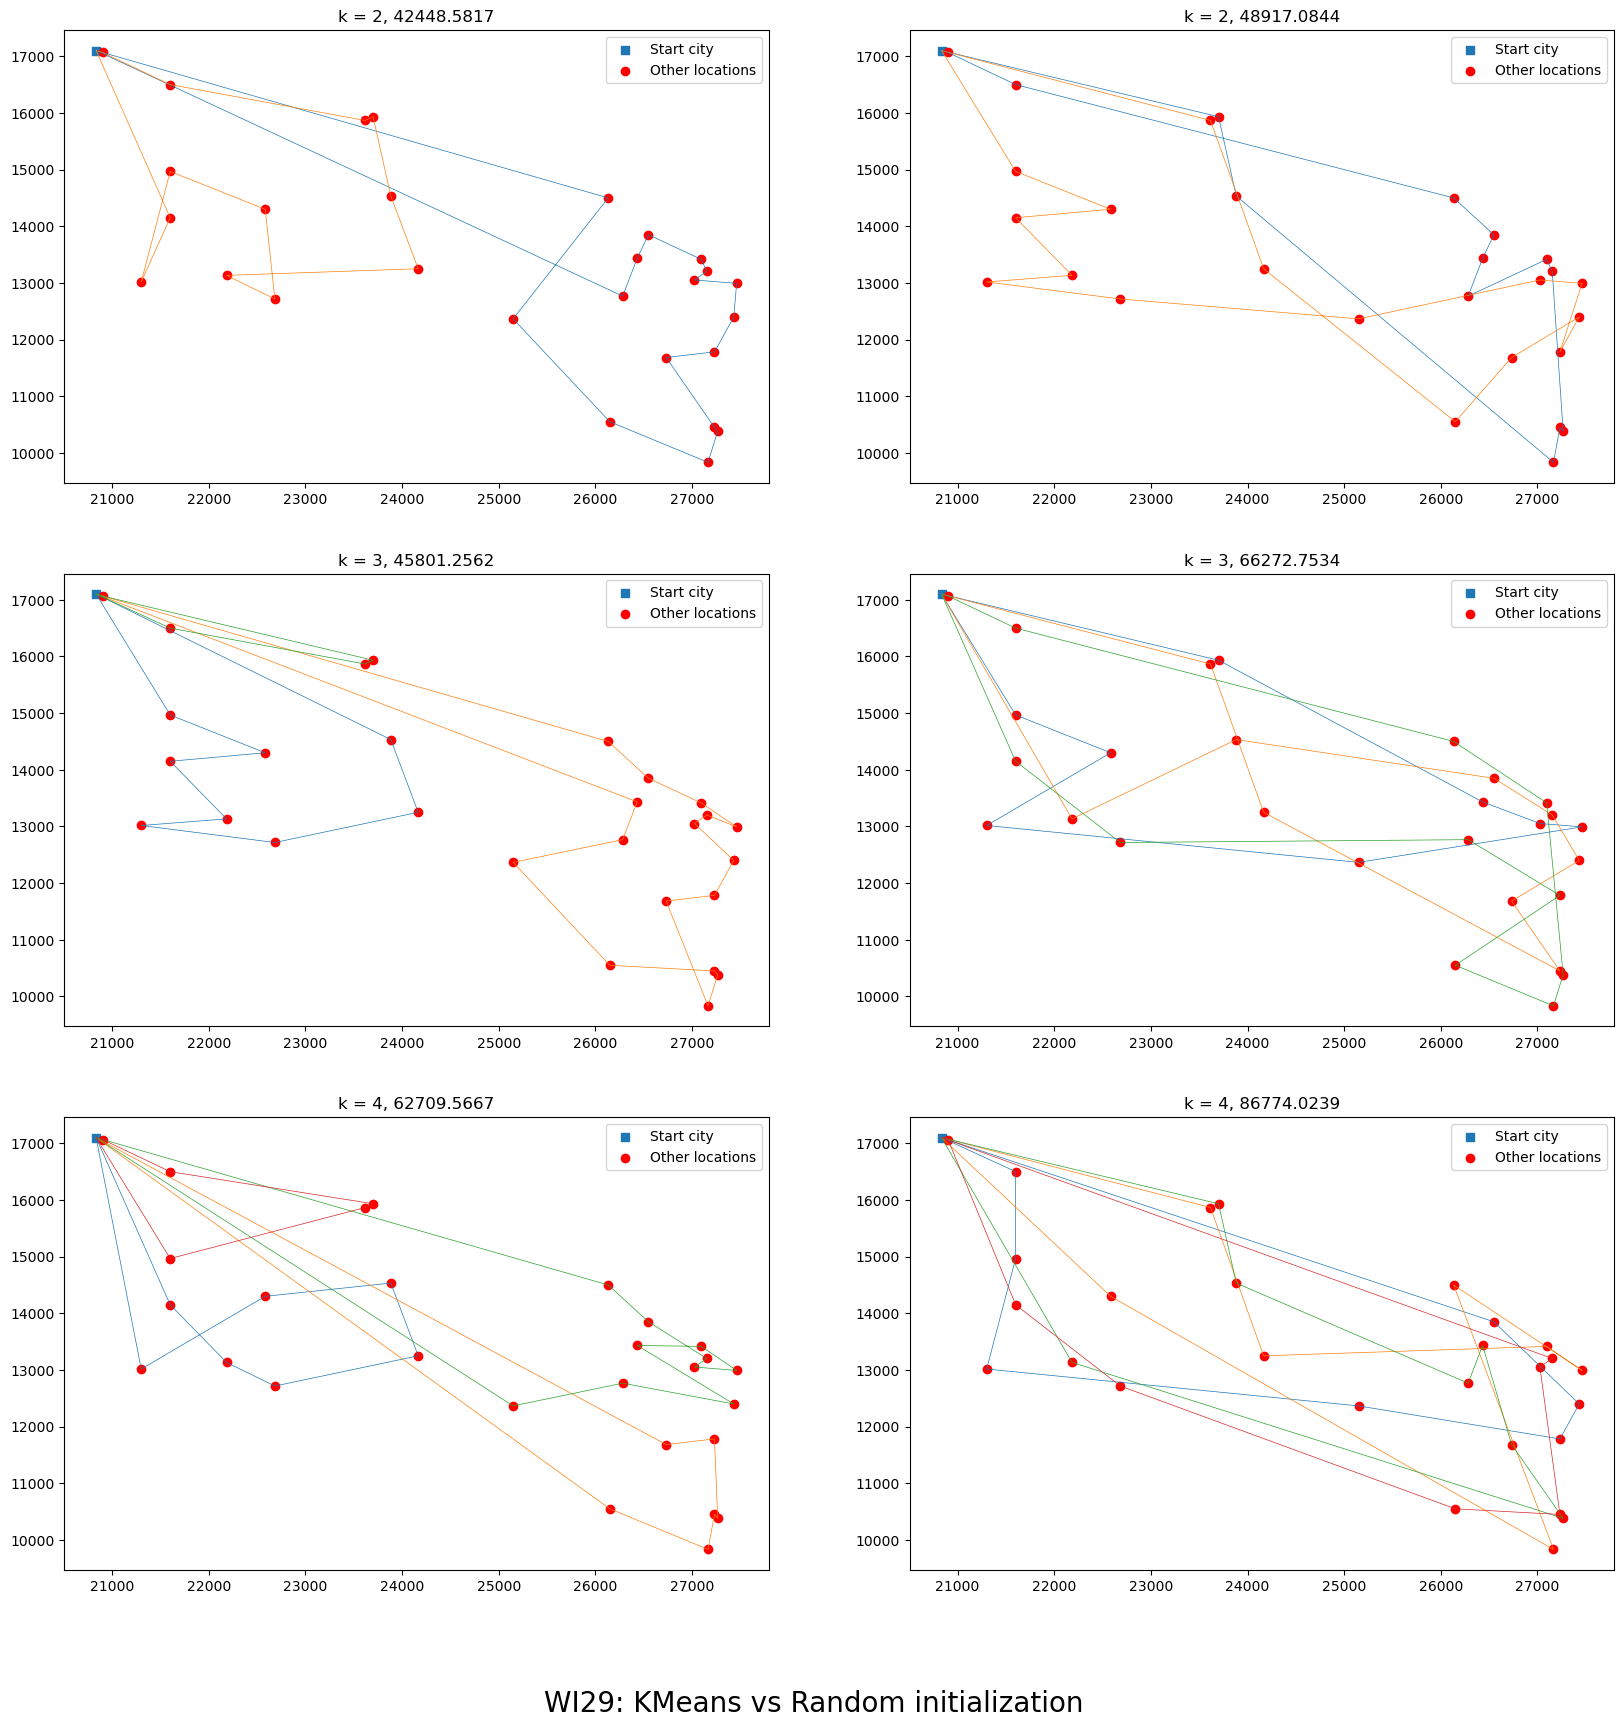

In [45]:
fig, axs = plt.subplots(3,2,figsize=(20,20))

plt.suptitle("WI29: KMeans vs Random initialization", y=0.05, fontsize=20)
#plotting KMeans

for i in range(3):
    routes = km_data[i][0]
    length = km_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,0].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,0].scatter(xs[1:], ys[1:], color='red')
    axs[i,0].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,0].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,0].plot(xs, ys, linewidth=0.5)   
    

# plotting random

for i in range(3):
    routes = rand_data[i][0]
    length = rand_data[i][1]
    
    xs = [g.nodes[u]['x'] for u in g.nodes]
    ys = [g.nodes[u]['y'] for u in g.nodes]

    axs[i,1].scatter(g.nodes[0]['x'], g.nodes[0]['y'], marker='s')    
    axs[i,1].scatter(xs[1:], ys[1:], color='red')
    axs[i,1].set_title(f'k = {len(routes)}, {np.round(length, 4)}')
    axs[i,1].legend(['Start city', 'Other locations'])

    for route in routes:
        xs = [g.nodes[u]['x'] for u in route]
        ys = [g.nodes[u]['y'] for u in route]

        xs.append(xs[0])
        ys.append(ys[0])
        axs[i,1].plot(xs, ys, linewidth=0.5)